In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from collections import Counter

# Load and preprocess MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Use a smaller subset of the MNIST dataset
subset_size = 10000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

In [4]:
# Define a convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
autoencoder.fit(X_train_subset, X_train_subset, epochs=20, batch_size=256, shuffle=True)


# Extract encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_train_subset)
encoded_imgs = encoded_imgs.reshape((subset_size, -1))


Epoch 1/20
40/40 [==============================] - 38s 935ms/step - loss: 0.4198
Epoch 2/20
40/40 [==============================] - 31s 782ms/step - loss: 0.1338
Epoch 3/20
40/40 [==============================] - 18s 451ms/step - loss: 0.1055
Epoch 4/20
40/40 [==============================] - 20s 495ms/step - loss: 0.0938
Epoch 5/20
40/40 [==============================] - 18s 454ms/step - loss: 0.0883
Epoch 6/20
40/40 [==============================] - 19s 469ms/step - loss: 0.0850
Epoch 7/20
40/40 [==============================] - 22s 543ms/step - loss: 0.0827
Epoch 8/20
40/40 [==============================] - 18s 454ms/step - loss: 0.0810
Epoch 9/20
40/40 [==============================] - 18s 447ms/step - loss: 0.0799
Epoch 10/20
40/40 [==============================] - 19s 474ms/step - loss: 0.0787
Epoch 11/20
40/40 [==============================] - 18s 445ms/step - loss: 0.0781
Epoch 12/20
40/40 [==============================] - 18s 441ms/step - loss: 0.0770
Epoch 13/20
4

In [5]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(encoded_imgs)

# Apply t-SNE with parameter tuning
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
X_tsne = tsne.fit_transform(encoded_imgs)

# Apply UMAP with parameter tuning
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=0)
X_umap = umap_model.fit_transform(encoded_imgs)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



PCA:
Silhouette Score: 0.0550
Adjusted Rand Index: 0.1365
Normalized Mutual Information: 0.2336
Cluster Purity: 0.3557

t-SNE:
Silhouette Score: 0.0848
Adjusted Rand Index: 0.5562
Normalized Mutual Information: 0.6649
Cluster Purity: 0.6983

UMAP:
Silhouette Score: 0.0954
Adjusted Rand Index: 0.6962
Normalized Mutual Information: 0.7851
Cluster Purity: 0.8256

Autoencoder:
Silhouette Score: 0.1220
Adjusted Rand Index: 0.3653
Normalized Mutual Information: 0.4844
Cluster Purity: 0.5839


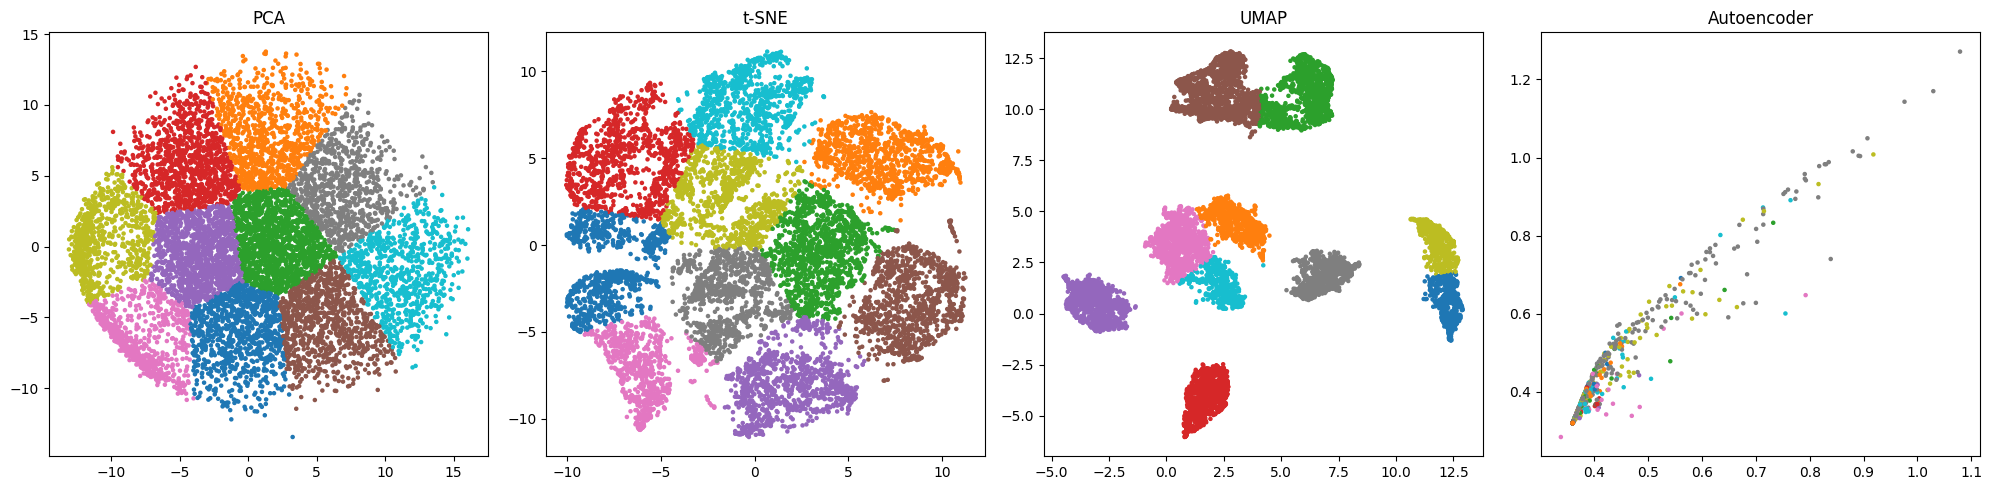

In [6]:
# Perform KMeans clustering on the reduced data
kmeans_pca = KMeans(n_clusters=10, random_state=0).fit(X_pca)
kmeans_tsne = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
kmeans_umap = KMeans(n_clusters=10, random_state=0).fit(X_umap)
kmeans_autoencoder = KMeans(n_clusters=10, random_state=0).fit(encoded_imgs)

# Define a function to compute cluster purity
def cluster_purity(y_true, y_pred):
    cluster_labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        most_common = Counter(y_true[mask]).most_common(1)[0][0]
        cluster_labels[mask] = most_common
    return np.mean(cluster_labels == y_true)

# Evaluate clustering performance
metrics = {
    'Silhouette Score': silhouette_score,
    'Adjusted Rand Index': adjusted_rand_score,
    'Normalized Mutual Information': normalized_mutual_info_score,
    'Cluster Purity': cluster_purity
}

results = {
    'PCA': kmeans_pca.labels_,
    't-SNE': kmeans_tsne.labels_,
    'UMAP': kmeans_umap.labels_,
    'Autoencoder': kmeans_autoencoder.labels_
}

for method, labels in results.items():
    print(f"\n{method}:")
    for metric_name, metric in metrics.items():
        score = metric(y_train_subset, labels) if metric_name != 'Silhouette Score' else metric(encoded_imgs, labels)
        print(f"{metric_name}: {score:.4f}")

# Visualize the results
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='tab10', s=5)
plt.title('PCA')

plt.subplot(1, 4, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_tsne.labels_, cmap='tab10', s=5)
plt.title('t-SNE')

plt.subplot(1, 4, 3)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_umap.labels_, cmap='tab10', s=5)
plt.title('UMAP')

plt.subplot(1, 4, 4)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=kmeans_autoencoder.labels_, cmap='tab10', s=5)
plt.title('Autoencoder')

plt.tight_layout()
plt.show()
